In [1]:
# -*- coding: utf-8 -*-
"""
03_model_comparison.ipynb

Comparison of OCR Pipelines:
- YOLO + CRNN (Ours)
- YOLO + TrOCR
- EasyOCR (End-to-End)
"""

USE_COLAB = True

if USE_COLAB:
    from google.colab import drive
    drive.mount("/content/drive")
    PROJECT_ROOT = "/content/drive/MyDrive/Information-Extraction-from-Image"
else:
    PROJECT_ROOT = os.path.abspath(".")

print("PROJECT_ROOT:", PROJECT_ROOT)


Mounted at /content/drive
PROJECT_ROOT: /content/drive/MyDrive/Information-Extraction-from-Image


In [2]:
# ===============================
# Install dependencies
# ===============================
!pip install -r {PROJECT_ROOT}/requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 76.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing

In [3]:
# ===============================
# Standard Library
# ===============================
import os
import sys
import time
import random
import pickle
import json

# ===============================
# Third-party Libraries
# ===============================
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from ultralytics import YOLO
import ultralytics

import easyocr
from transformers import TrOCRProcessor, VisionEncoderDecoderModel


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [4]:
DATASET_DIR = os.path.join(PROJECT_ROOT, "datasets/SceneTrialTrain")
CACHE_DIR = os.path.join(PROJECT_ROOT, "cache")
MODEL_DIR = os.path.join(PROJECT_ROOT, "model")

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

ultralytics.checks()

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 21.4/107.7 GB disk)


In [5]:
with open(os.path.join(CACHE_DIR, "val_data.pkl"), "rb") as f:
    cache = pickle.load(f)

val_yolo_data = cache["val_yolo_data"]
image_paths = cache["image_paths"]
image_labels = cache["image_labels"]
bounding_boxes = cache["bounding_boxes"]

In [6]:
from src.pipeline import (
    inference_yolo_crnn,
    inference_yolo_trocr,
    inference_easyocr,
)

from src.evaluation import (
    evaluate_model,
)

Comparison of 3 models on the test dataset:
- **YOLO + CRNN (Ours)**
- **YOLO + TrOCR**
- **EasyOCR (End-to-End)**

Evaluation based on:

- Character Accuracy

- Word Accuracy

- Inference Speed

With 2 confidence thresholds: **0.3**

#1. Vocabulary & CRNN Config

In [7]:
CHARS = "0123456789abcdefghijklmnopqrstuvwxyz-"
BLANK_CHAR = "-"

char_to_idx = {c: i + 1 for i, c in enumerate(sorted(CHARS))}
idx_to_char = {i: c for c, i in char_to_idx.items()}

VOCAB_SIZE = len(CHARS)

CRNN_CONFIG = {
    "hidden_size": 256,
    "n_layers": 3,
    "dropout": 0.2,
    "unfreeze_layers": 3,
}


#2. Load YOLO + CRNN Models

In [8]:
from src.recognition import CRNN

yolo_model_path = os.path.join(MODEL_DIR, "yolo/best.pt")
crnn_model_path = os.path.join(MODEL_DIR, "cnn/ocr_crnn.pt")

yolo_det = YOLO(yolo_model_path)
print("YOLO loaded")

crnn_model = CRNN(
    vocab_size=VOCAB_SIZE,
    **CRNN_CONFIG,
).to(DEVICE)

crnn_model.load_state_dict(
    torch.load(crnn_model_path, map_location=DEVICE)
)
crnn_model.eval()
print("CRNN loaded")


YOLO loaded


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

CRNN loaded


#3. Load TrOCR

In [9]:
print("Loading TrOCR...")
trocr_processor = TrOCRProcessor.from_pretrained(
    "microsoft/trocr-base-printed"
)
trocr_model = VisionEncoderDecoderModel.from_pretrained(
    "microsoft/trocr-base-printed"
).to(DEVICE)
trocr_model.eval()
print("TrOCR loaded")

Loading TrOCR...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

TrOCR loaded


#4. Load EasyOCR


In [10]:
easyocr_reader = easyocr.Reader(
    ["en"], gpu=torch.cuda.is_available()
)
print("EasyOCR loaded")

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteEasyOCR loaded


#5. Build Test Dataset (from YOLO Val)

In [11]:
test_samples = val_yolo_data[:50]
test_data = []

for img_rel_path, _ in test_samples:
    img_path = os.path.join(DATASET_DIR, img_rel_path)

    for p, labels, bbs in zip(image_paths, image_labels, bounding_boxes):
        if p != img_rel_path:
            continue

        for bb, label in zip(bbs, labels):
            x, y, w, h = map(int, bb)
            test_data.append(
                {
                    "image_path": img_path,
                    "bbox": (x, y, w, h),
                    "label": label,
                }
            )
        break

print(
    f"Prepared {len(test_data)} text regions "
    f"from {len(test_samples)} images"
)

Prepared 227 text regions from 50 images


#6. CRNN Transform

In [12]:
crnn_transform = transforms.Compose(
    [
        transforms.Resize((100, 420)),
        transforms.Grayscale(1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

#7. Evaluation (Confidence = 0.3)

In [13]:
from functools import partial

# Test with confidence threshold 0.3
conf_threshold = 0.3
print(f"\n\n{'#'*80}")
print(f"# EVALUATION WITH CONFIDENCE THRESHOLD = {conf_threshold}")
print(f"{'#'*80}\n")

# Evaluate YOLO + CRNN
yolo_crnn_infer = partial(
    inference_yolo_crnn,
    yolo_det=yolo_det,
    crnn_transform=crnn_transform,
    crnn_inference=crnn_model,
    idx_to_char=idx_to_char,
)

results_yolo_crnn = evaluate_model(
    yolo_crnn_infer,
    test_data,
    "YOLO + CRNN (Ours)",
    conf_threshold=conf_threshold
)

# Evaluate YOLO + TrOCR
yolo_trocr_infer = partial(
    inference_yolo_trocr,
    yolo_det=yolo_det,
    trocr_processor=trocr_processor,
    trocr_model=trocr_model,
)

results_yolo_trocr = evaluate_model(
    yolo_trocr_infer,
    test_data,
    "YOLO + TrOCR",
    conf_threshold=conf_threshold
)

# Evaluate EasyOCR (end-to-end)
easyocr_infer = partial(
    inference_easyocr,
    easyocr_reader=easyocr_reader,
)

results_easyocr = evaluate_model(
    easyocr_infer,
    test_data,
    "EasyOCR (End-to-End)",
    conf_threshold=conf_threshold
)

# Store results for comparison
results_03 = [results_yolo_crnn, results_yolo_trocr, results_easyocr]



################################################################################
# EVALUATION WITH CONFIDENCE THRESHOLD = 0.3
################################################################################


Evaluating YOLO + CRNN (Ours)

Results for YOLO + CRNN (Ours):
  - Character Accuracy : 90.75%
  - Word Accuracy      : 76.92%
  - Avg Time / Image   : 2.9873s
  - Images Processed   : 49
  - Matched Regions    : 195

Evaluating YOLO + TrOCR


/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(



Results for YOLO + TrOCR:
  - Character Accuracy : 91.53%
  - Word Accuracy      : 76.41%
  - Avg Time / Image   : 19.2782s
  - Images Processed   : 49
  - Matched Regions    : 195

Evaluating EasyOCR (End-to-End)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument i


Results for EasyOCR (End-to-End):
  - Character Accuracy : 81.16%
  - Word Accuracy      : 54.46%
  - Avg Time / Image   : 11.0657s
  - Images Processed   : 49
  - Matched Regions    : 112


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


#8. Results Table

In [14]:
import pandas as pd

# Display comparison results for confidence threshold 0.3
print("\n" + "="*100)
print("COMPARISON RESULTS - CONFIDENCE THRESHOLD = 0.3")
print("="*100)

results = [r for r in results_03 if r]
if len(results) > 0:
    df_03 = pd.DataFrame(results)
    df_03 = df_03[['model', 'char_acc', 'word_acc', 'avg_time', 'matched_regions']]
    df_03.columns = ['Model', 'Char Acc (%)', 'Word Acc (%)', 'Speed (s/img)', 'Matched Regions']
    print(df_03.to_string(index=False))
    best_char_03 = df_03.loc[df_03['Char Acc (%)'].idxmax(), 'Model']
    best_word_03 = df_03.loc[df_03['Word Acc (%)'].idxmax(), 'Model']

    print("\n" + "="*100)
    print("SUMMARY")
    print("="*100)
    print(f"Confidence 0.3 - Best Char Acc: {best_char_03} | Best Word Acc: {best_word_03}")


COMPARISON RESULTS - CONFIDENCE THRESHOLD = 0.3
               Model  Char Acc (%)  Word Acc (%)  Speed (s/img)  Matched Regions
  YOLO + CRNN (Ours)     90.752784     76.923077       2.987309              195
        YOLO + TrOCR     91.533326     76.410256      19.278250              195
EasyOCR (End-to-End)     81.158828     54.464286      11.065697              112

SUMMARY
Confidence 0.3 - Best Char Acc: YOLO + TrOCR | Best Word Acc: YOLO + CRNN (Ours)


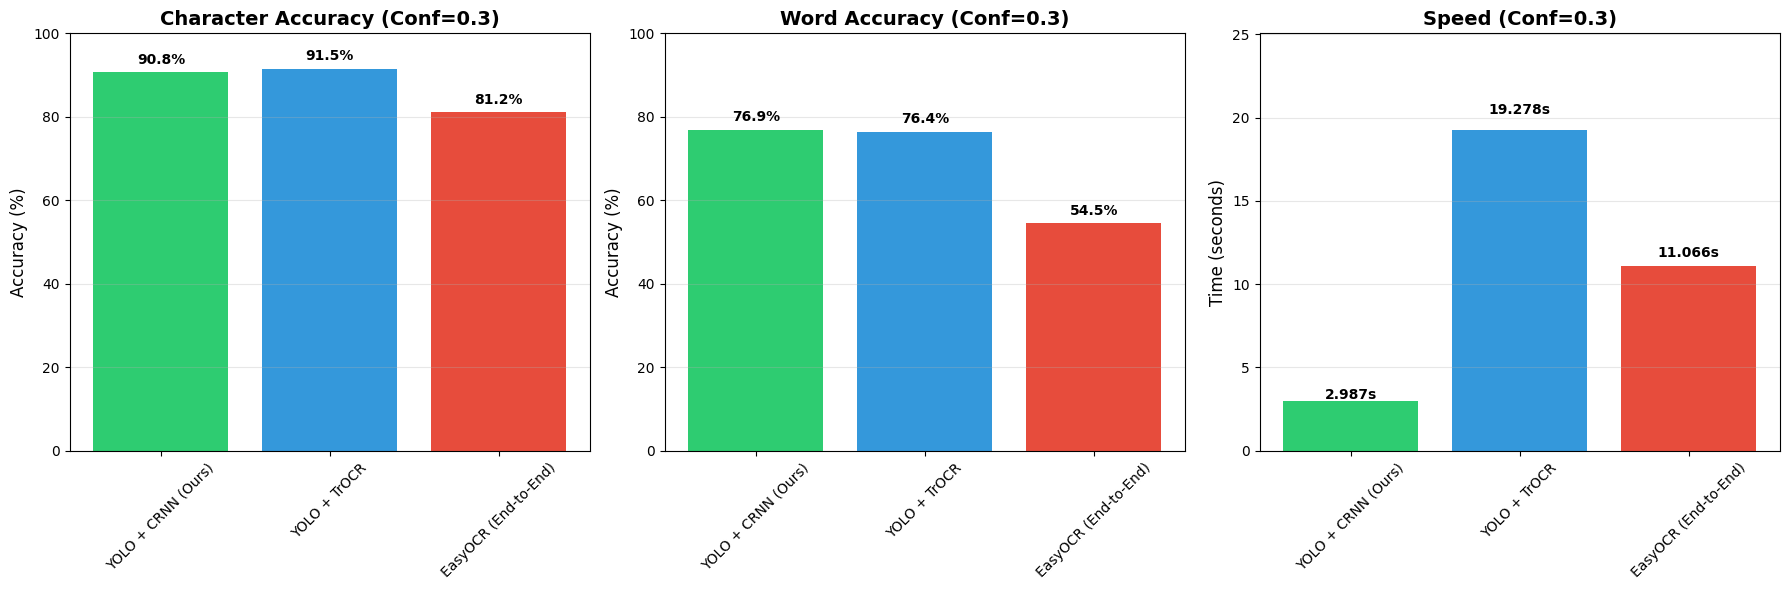

In [15]:
if len(results_03) > 0:
    # Visualize results for confidence threshold 0.3
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    colors = ['#2ecc71', '#3498db', '#e74c3c']
    df = df_03

    # Character Accuracy
    axes[0].bar(df['Model'], df['Char Acc (%)'], color=colors)
    axes[0].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0].set_title('Character Accuracy (Conf=0.3)', fontsize=14, fontweight='bold')
    axes[0].set_ylim([0, 100])
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(df['Char Acc (%)']):
        axes[0].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=10)

    # Word Accuracy
    axes[1].bar(df['Model'], df['Word Acc (%)'], color=colors)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Word Accuracy (Conf=0.3)', fontsize=14, fontweight='bold')
    axes[1].set_ylim([0, 100])
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    for i, v in enumerate(df['Word Acc (%)']):
        axes[1].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=10)

    # Speed
    axes[2].bar(df['Model'], df['Speed (s/img)'], color=colors)
    axes[2].set_ylabel('Time (seconds)', fontsize=12)
    axes[2].set_title('Speed (Conf=0.3)', fontsize=14, fontweight='bold')
    axes[2].grid(axis='y', alpha=0.3)
    axes[2].tick_params(axis='x', rotation=45)

    max_speed = float(df['Speed (s/img)'].max())
    axes[2].set_ylim(0, max_speed * 1.3)

    for i, v in enumerate(df['Speed (s/img)']):
        axes[2].text(i, v + v * 0.05, f'{v:.3f}s', ha='center', fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("No results to visualize!")


SAMPLE PREDICTIONS VISUALIZATION (2 Sample Images)

────────────────────────────────────────────────────────────────────────────────────────────────────
SAMPLE IMAGE 25: /content/drive/MyDrive/Information-Extraction-from-Image/datasets/SceneTrialTrain/lfsosa_12.08.2002/IMG_2654.JPG
────────────────────────────────────────────────────────────────────────────────────────────────────
Ground Truth Labels: ['arena', 'leisure', 'limited', 'office', 'registered', 'services']
Total regions in this image: 6



/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


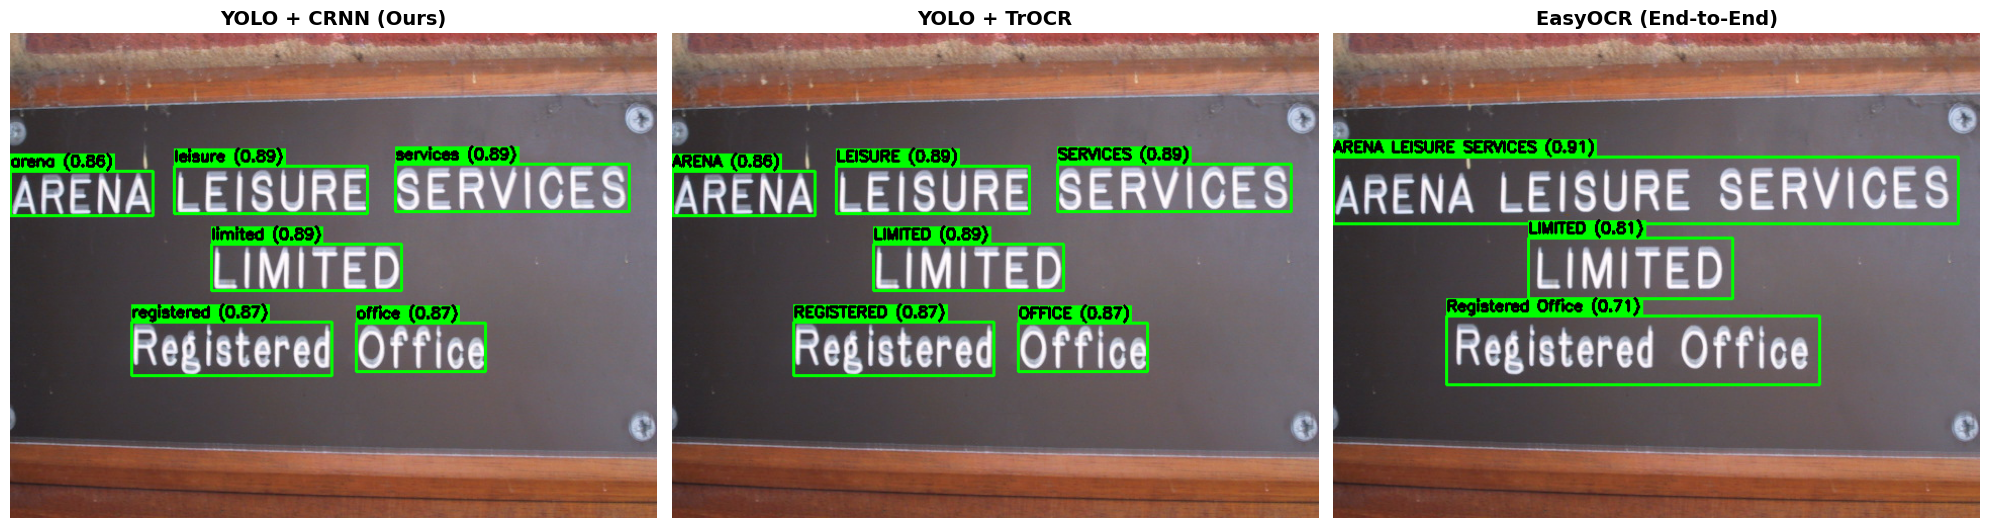

  YOLO+CRNN detected: 6 regions
    1. services (conf: 0.894)
    2. limited (conf: 0.892)
    3. leisure (conf: 0.892)
    4. office (conf: 0.875)
    5. registered (conf: 0.873)
    6. arena (conf: 0.859)

  YOLO+TrOCR detected: 6 regions
    1. SERVICES (conf: 0.894)
    2. LIMITED (conf: 0.892)
    3. LEISURE (conf: 0.892)
    4. OFFICE (conf: 0.875)
    5. REGISTERED (conf: 0.873)
    6. ARENA (conf: 0.859)

  EasyOCR detected: 3 regions
    1. ARENA LEISURE SERVICES (conf: 0.905)
    2. LIMITED (conf: 0.807)
    3. Registered Office (conf: 0.711)



────────────────────────────────────────────────────────────────────────────────────────────────────
SAMPLE IMAGE 144: /content/drive/MyDrive/Information-Extraction-from-Image/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1288.JPG
────────────────────────────────────────────────────────────────────────────────────────────────────
Ground Truth Labels: ['under', 'wear', 's']
Total regions in this image: 3



/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


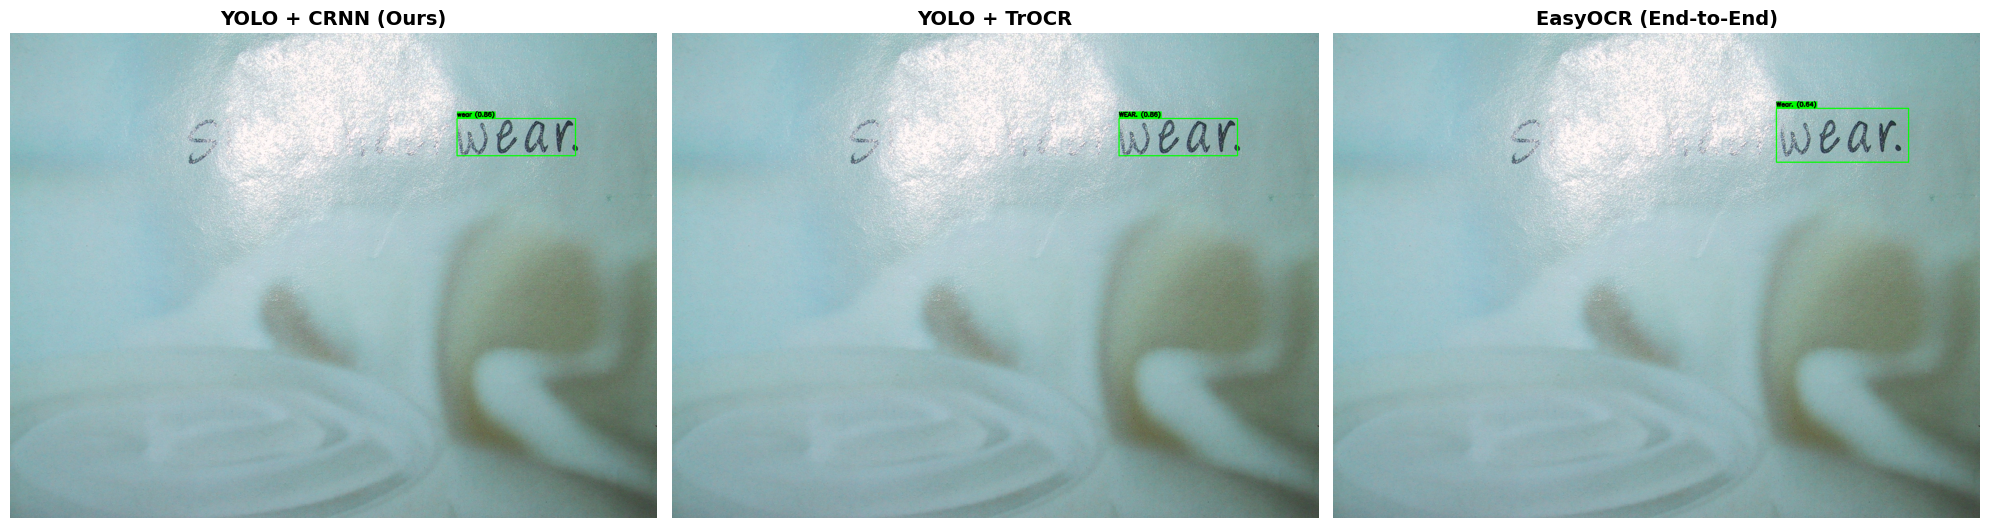

  YOLO+CRNN detected: 1 regions
    1. wear (conf: 0.863)

  YOLO+TrOCR detected: 1 regions
    1. WEAR. (conf: 0.863)

  EasyOCR detected: 1 regions
    1. Wear. (conf: 0.638)




In [16]:
# Visualize predictions from 3 models on 2 sample images
print("\n" + "="*100)
print("SAMPLE PREDICTIONS VISUALIZATION (2 Sample Images)")
print("="*100)

# Select 2 random sample images
sample_indices = random.sample(range(len(test_data)), min(2, len(test_data)))

for sample_idx in sample_indices:
    sample_img_path = test_data[sample_idx]['image_path']

    print(f"\n{'─'*100}")
    print(f"SAMPLE IMAGE {sample_idx + 1}: {sample_img_path}")
    print(f"{'─'*100}")

    # Get ground truth labels for this image
    gt_labels = [item['label'] for item in test_data if item['image_path'] == sample_img_path]
    print(f"Ground Truth Labels: {gt_labels}")
    print(f"Total regions in this image: {len(gt_labels)}\n")

    # Get predictions with confidence threshold 0.3
    preds_crnn = inference_yolo_crnn(sample_img_path, yolo_det, crnn_transform, crnn_model, idx_to_char, conf_threshold=0.3)
    preds_trocr = inference_yolo_trocr(sample_img_path, yolo_det, trocr_processor, trocr_model, conf_threshold=0.3)
    preds_easyocr = inference_easyocr(sample_img_path, easyocr_reader, conf_threshold=0.3)

    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))

    for idx, (preds, title) in enumerate([
        (preds_crnn, 'YOLO + CRNN (Ours)'),
        (preds_trocr, 'YOLO + TrOCR'),
        (preds_easyocr, 'EasyOCR (End-to-End)')
    ]):
        img = cv2.imread(sample_img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        for pred in preds:
            x, y, w, h = pred['bbox']
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

            # Add text
            text = pred['text']
            conf = pred['confidence']
            label = f"{text} ({conf:.2f})"

            # Background for text
            (text_w, text_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            cv2.rectangle(img, (x, y-text_h-5), (x+text_w, y), (0, 255, 0), -1)
            cv2.putText(img, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

        axes[idx].imshow(img)
        axes[idx].set_title(title, fontsize=14, fontweight='bold')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # Print detection results
    print(f"  YOLO+CRNN detected: {len(preds_crnn)} regions")
    for i, pred in enumerate(preds_crnn):
        print(f"    {i+1}. {pred['text']} (conf: {pred['confidence']:.3f})")

    print(f"\n  YOLO+TrOCR detected: {len(preds_trocr)} regions")
    for i, pred in enumerate(preds_trocr):
        print(f"    {i+1}. {pred['text']} (conf: {pred['confidence']:.3f})")

    print(f"\n  EasyOCR detected: {len(preds_easyocr)} regions")
    for i, pred in enumerate(preds_easyocr):
        print(f"    {i+1}. {pred['text']} (conf: {pred['confidence']:.3f})")

    print("\n")